# Multimodality segmentation of brain lesions in patients with Multiple Sclerosis

The goal of this project is to segment white matter lesions in patients with Multiple Sclerosis by using a custom segmentation algorithm using multimodality (MPRAGE and FLAIR). This project is part of the course WSBIM2243 given at UCLouvain in Belgium. 

The method is compared with classical method such as Otsu and Expectation-Maximization.

<img src="img/MS.png"/>

The workflow is the following and each part is detailled in the notebook 

<img src="img/pipeline.png"/>

GitHub repo : https://github.com/amanpreetsingh-BE/multimodality-segmentation <br/><br/><br/>
!!! In order to execute the notebook, please use it with Docker to avoid any packages conflitcts or path name !!! <br/> The exact instructions are on the README of the GitHub repo.

## 0.1 Import dependencies

In [39]:
# Required imports (installed with Docker)
import os,sys,inspect, platform
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
sys.path.insert(1, './../utils/')

import warnings
warnings.simplefilter("ignore", FutureWarning)

from dicom2bids import *
from utils import *

from matplotlib import pyplot as plt

print("[INFO] Imports done")

[INFO] Imports done


## 0.2 Define paths

In [2]:
# Creating Output BIDS directory: if run on Docker no need to provide bids_dir 
# but if run without docker, you need to provide the bids_dir path and comment the try
# except block (bids_dir folder needs to contains folder hierarchy as in the try except block)
# bids_dir = outputs of the program

try:
    os.mkdir("/data/bids_dir")
    os.mkdir("/data/bids_dir/derivatives")
    os.mkdir("/data/bids_dir/derivatives/transformations")
    os.mkdir("/data/bids_dir/derivatives/stats")
    os.mkdir("/data/bids_dir/derivatives/samseg")
    os.mkdir("/data/bids_dir/derivatives/segmentations")
except FileExistsError:
    print("[Exception Caught] BIDS directory already exists.")

bids_dir = "/data/bids_dir"   # for instance if not on docker 
                              # a local path bids_dir = "../../Documents/myFolderontainingDatas/bids_dir"

# Path to dcm2niix.exe converter

if(platform.system() == 'Darwin'):
    dicom2niix_path = "../utils/dcm2niix" # for Mac users
    
elif(platform.system() == 'Windows'):
    dicom2niix_path = "../utils/dcm2niix.exe" # for Windows users
else:
    dicom2niix_path = "../utils/dcm2niix-lnx" # for Linux users

print("[INFO] Defined paths done")

[INFO] Defined paths done


## 1. Import and convert DICOM to nifti and put in BIDS format

The first step is to convert the raw DICOM files downloaded from the MRI software into an organized structure with folders and consistent naming (BIDS format (brain imaging data structure)). All utility functions are stored in the 'dicom2bids.py' file.



In [3]:
# Path to DICOM directory 
# Again here, no need to change the path if runned on docker but in local, you need to 
# provide the folder path containing the dicoms ! 
# directory = inputs of the program

# directory = "../../Documents/da/"

directory = "/data/"   # for instance if not on docker 
                      # a local path directory = "../../Documents/myFolderontainingDatas/"

# Convert all DICOMs
dicom_series = convert_all_dicoms(directory, dicom2niix_path, convert=True)

# Create directories in the BIDS file structure by giving an incremental id
pat_id, session = make_directories(bids_dir,pat_id=None,session=None)
# To specify the patient id:
# pat_id, session = make_directories(bids_dir,pat_id='ID_TO_SPECIFY',session=None)
# To specify the patient id and session:
# pat_id, session = make_directories(bids_dir,pat_id='ID_TO_SPECIFY',session='SESSION_TO_SPECIFY')

# Rename and move all (interesting) converted files into the bids directory
rename_and_move_nifti(dicom_series, bids_dir, pat_id, session)

print(f"[INFO] ID {pat_id} was given to this subject")
print("[INFO] Done")

[INFO] Starting to convert ...
SUBDIR: ../../Documents/da/madameX/3DT2_065mm_iso_0	DIRS: []
SUBDIR: ../../Documents/da/madameX/t1_mprage_sag_Natif_SwissMS_0	DIRS: []
SUBDIR: ../../Documents/da/madameX/t2_spc3d_sag_flair_64cx_0	DIRS: []
[INFO] Converted all dicom files to compressed nifti
[]
SERIES: 3DT2*_0.65mm_iso
   Filenames: ['_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_14_o', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_15_phg', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_14_', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_15_phk', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_14_c', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_14_a', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_15_phi', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_15_phe', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_14_m', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_15_ph', '_3DT2_065mm_iso_0_3DT2_0.65mm_iso_20180807084817_15_pha', '_3DT2_065mm_iso_0_3DT2_0.65mm_

In [4]:
# There are multiple patients with each an assigned id, define patient to work with (for instance here the
# patient with id 001). 
#pat_id = '001'
subject = pat_id

## 2. Registrate MPRAGE to FLAIR images

The next step is to registrate the MPRAGE on FLAIR. 
MPRAGE modality is used to make a mask of the white and grey matter (WM-GM highly visible on MPRAGE) and the FLAIR is used to detect the lesions (lesions highly visible on FLAIR). The mask will allow to exclude the lesions in grey matter which are smaller and more challening to detect. The output is saved in 'derivatives/transformations' folder of the BIDS structure.

For this purpose we used simpleITK library <br/>

Note : the optimizer used is the gradient descent, the metric is the mutual information and the method is designated as 'Euler3DTransform' which is a rigid 3D transform

In [5]:
# registrate patient
mprage2flair_registration(bids_dir, subject)
print("[INFO] Done : registreted image stored in 'derivatives/transformations' folder of BIDS structure")

Final metric value: -0.668055680162938
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 34.
[INFO] Done : registreted image stored in 'derivatives/transformations' folder of BIDS structure


## 3. Compute Brain mask (skull stripping)
The next step is to extract the brain mask (skull stripping) from the MPRAGE contrast and apply it to FLAIR. To do this, we used FSL on earlier version but it was too heavy and complicated to include in a jupyter notebook. Therefore, we used deepbrain library which uses CNN to extract the brain (tensorflow based). The output is saved in 'derivatives/transformations' folder of the BIDS structure.

In [6]:
# Compute brainmask on registered MPRAGE
make_brainmask(bids_dir, subject, save_mask=True)
print("[INFO] Done : the MPRAGE brain and brainmask stored in 'derivatives/transformations' folder of BIDS structure")

Instructions for updating:
Use tf.gfile.GFile.
[INFO] Done : the MPRAGE brain and brainmask stored in 'derivatives/transformations' folder of BIDS structure


## 4. Apply brain mask on FLAIR

In the step 4, we computed the mask of the brain on the MPRAGE, and the same mask can be applied to the FLAIR in order to extract the brain (since they are registered) 

In [7]:
# Apply mask on FLAIR
apply_brainmask(bids_dir, subject)
print("[INFO] Done : binary brainmask applied, FLAIR brain stored in 'derivatives/transformations' folder of BIDS structure")

[INFO] Done : binary brainmask applied, FLAIR brain stored in 'derivatives/transformations' folder of BIDS structure


Text(0.5, 1.0, 'MPRAGE registered on FLAIR')

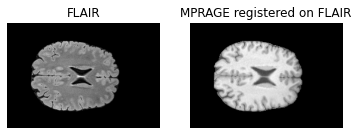

In [8]:
# Illustration of the brains skull stripped and registred

FLAIR = nib.load(bids_dir+'/derivatives/transformations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_FLAIR_brain.nii.gz')
FLAIR = FLAIR.get_fdata()
MPRAGE_REG = nib.load(bids_dir+'/derivatives/transformations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_MPRAGE_brain.nii.gz')
MPRAGE_REG = MPRAGE_REG.get_fdata()

fig = plt.figure()

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(FLAIR[:,:,170], cmap=plt.cm.gray)
plt.title('FLAIR')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(MPRAGE_REG[:,:,170], cmap=plt.cm.gray)
plt.title('MPRAGE registered on FLAIR')


## 5. Segment grey matter (GM) and white matter (WM)

For the moment, we have the brains (without the skull) of the MPRAGE and FLAIR and both are registered.
The final goal is to segment lesions in white matter only (lesions in gray matter are more challenging to detect). Therefore, once we get our skull stripped MPRAGE and FLAIR images, we segment the white and gray matter on the MPRAGE (WM and GM easily visible) using Otsu.

In [9]:
# Make the grey matter-white matter segmentation
make_gm_wm_mask(bids_dir, subject)
print("[INFO] Done : MPRAGE is segmented into 2 class, stored in 'derivatives/segmentations' folder of BIDS structure")

[INFO] Done : MPRAGE is segmented into 2 class, stored in 'derivatives/segmentations' folder of BIDS structure


Text(0.5, 1.0, 'WM-GM segmented on MPRAGE')

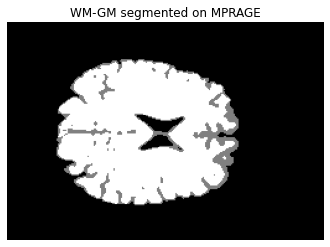

In [10]:
# Illustration of the MPRAGE segmentation

MPRAGE_seg = nib.load(bids_dir+'/derivatives/segmentations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_gm_wm.nii.gz')
MPRAGE_seg = MPRAGE_seg.get_fdata()
fig = plt.figure()
plt.axis('off')
plt.imshow(MPRAGE_seg[:,:,170], cmap=plt.cm.gray)
plt.title('WM-GM segmented on MPRAGE')

## 6. Make the lesion mask

The goal of this step is to Match histogram with reference image (or not) : 
 - Pick (or not) an intensity and a range for lesions. 
 - Apply median filter to smooth the mask and remove too small lesions
 - Exclude lesions whose center of mass in located in the gray matter


In [11]:
# Compute lesion mask without histogram matching to a reference image(not advised)
compute_lesion_mask(bids_dir, subject, intensity=260, range_down=40, range_up=40)

# Compute lesion mask with histogram matching to a reference image : 
# histogram_matching(bids_dir, subject)
# compute_lesion_mask(bids_dir, subject, intensity=1300 , range_down=150, range_up=350, matched=True)

Lesion 1/86: (37, 95, 120)> discarded (val = 0.0)
Lesion 2/86: (58, 100, 135)> retained
Lesion 3/86: (58, 111, 134)> retained
Lesion 4/86: (59, 100, 129)> retained
Lesion 5/86: (59, 138, 144)> retained
Lesion 6/86: (60, 104, 126)> retained
Lesion 7/86: (60, 116, 136)> retained
Lesion 8/86: (62, 102, 127)> retained
Lesion 9/86: (63, 115, 137)> retained
Lesion 10/86: (62, 137, 142)> retained
Lesion 11/86: (64, 80, 161)> retained
Lesion 12/86: (65, 75, 151)> retained
Lesion 13/86: (64, 122, 132)> retained
Lesion 14/86: (64, 136, 135)> retained
Lesion 15/86: (66, 86, 143)> discarded (val = 500.0)
Lesion 16/86: (66, 121, 140)> retained
Lesion 17/86: (69, 134, 136)> retained
Lesion 18/86: (68, 120, 134)> retained
Lesion 19/86: (69, 92, 148)> discarded (val = 500.0)
Lesion 20/86: (70, 103, 128)> retained
Lesion 21/86: (71, 88, 147)> discarded (val = 500.0)
Lesion 22/86: (70, 118, 138)> retained
Lesion 23/86: (71, 93, 149)> retained
Lesion 24/86: (74, 106, 102)> retained
Lesion 25/86: (73, 170

Text(0.5, 1.0, 'Lesion mask')

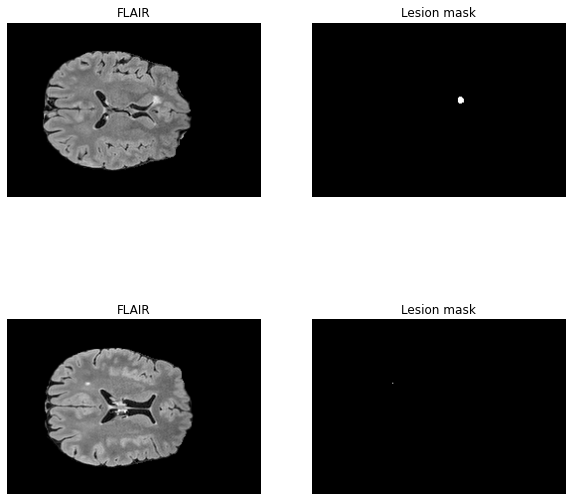

In [12]:
# Illustration of the Lesion segmentation found

FLAIR = nib.load(bids_dir+'/derivatives/transformations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_FLAIR_brain.nii.gz')
FLAIR = FLAIR.get_fdata()
lesions = nib.load(bids_dir+'/derivatives/segmentations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_lesion-mask.nii.gz')
lesions = lesions.get_fdata()

fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(FLAIR[:,:,158], cmap=plt.cm.gray)
plt.title('FLAIR')
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(lesions[:,:,158], cmap=plt.cm.gray)
plt.title('Lesion mask')
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(FLAIR[:,:,163], cmap=plt.cm.gray)
plt.title('FLAIR')
plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(lesions[:,:,163], cmap=plt.cm.gray)
plt.title('Lesion mask')

## 7. Region growing (TODO)

Finally, we can apply region growing on each lesion's 'center of mass' 

+Show result ! 

## 8. Comparison with OTSU method

Otsu is a binary method for segmentation (soft thresholding), it can only segment two classes. The images contains multiple class (WM, GM, bakcground, lesions, ..) and thus it is not very well suited for our application. 

Text(0.5, 1.0, 'FLAIR after Otsu')

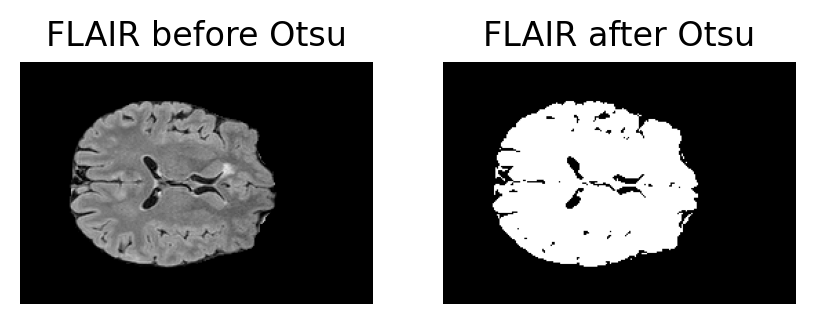

In [13]:
# Illustration of the implemented Otsu method

FLAIR = nib.load(bids_dir+'/derivatives/transformations/sub-'+subject+'/ses-01/sub-'+subject+'_ses-01_FLAIR_brain.nii.gz')
FLAIR = FLAIR.get_fdata()

I = (FLAIR)[:,:,158]
I = I / np.max(I) # scale to 0.0 and 1.0
I = (I/np.max(I))*255.0 # Grayscale normalization
rows = I.shape[0]    # Numbers of lines
cols = I.shape[1]    # Numbers of columns
N = rows*cols
n = np.zeros(256)
for i in range(0,rows):
    for j in range(0,cols):
        n[int(I[i,j])]+=1 
PMF = [x * (1/N) for x in n] # compute histogram

I_otsu = otsu(I, PMF) # otsu method (cfr utils.py)

fig = plt.figure(figsize=(5, 5), dpi=200)

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(I, cmap=plt.cm.gray)
plt.title('FLAIR before Otsu')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(I_otsu, cmap=plt.cm.gray)
plt.title('FLAIR after Otsu')

## 9. Comparison with EM method

The result of EM is highly dependant on the choice of the initial means and variances. 

./../utils/utils.py:313: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bin_edges = np.histogram(array, bins=255, normed=True)


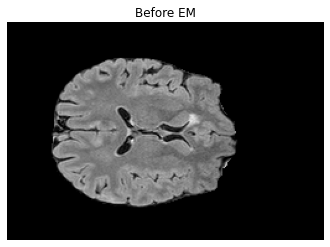

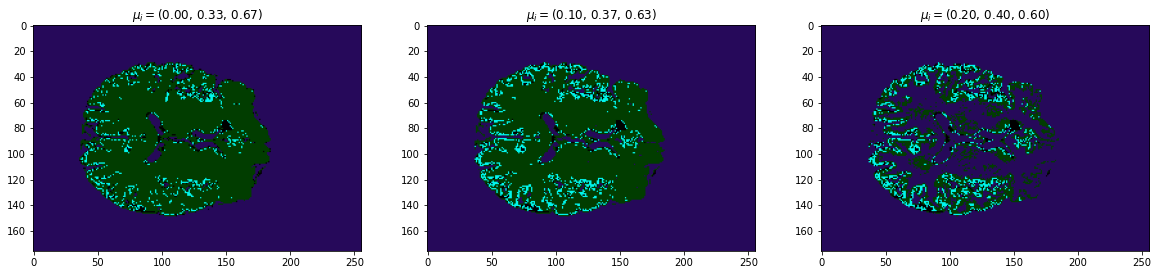

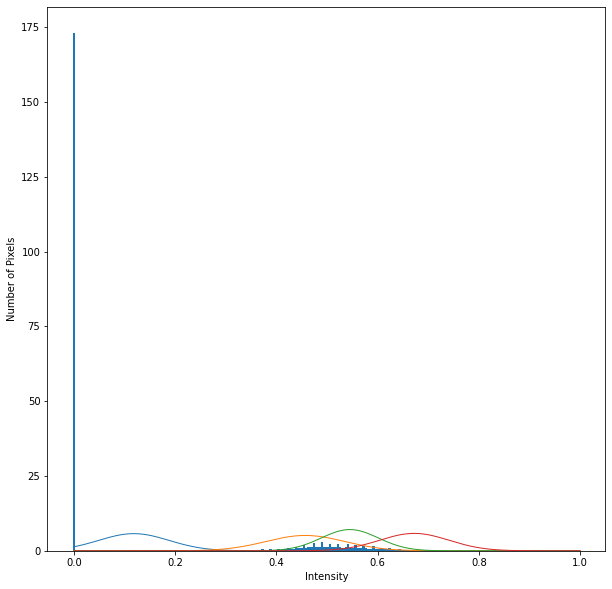

In [38]:
# Illustration of the implemented EM method

I = (FLAIR)[:,:,158]
I = I / np.max(I) # scale to 0.0 and 1.0

# before 

plt.figure()

plt.axis('off')
plt.imshow(I, cmap=plt.cm.gray)
plt.title('Before EM')

## Get only non zeros pixels from the image (Use functions from previous cell)
foregroundMask = getForegroundMask(I)
foregroundArray = getForegroundArray(I, foregroundMask)

## Define classes for the classification
classList = ['GreyMatter', 'WhiteMatter', 'CerebrospinalFluid', 'Lesions']
numberOfClasses = len(classList)

## Initial conditions,trying 1 differents initial values
numberTest = 3
initialMeansArray = np.zeros((numberTest,numberOfClasses))
initialStdsArray = np.zeros((numberTest,numberOfClasses))

initialMeansArray[0,:] = np.linspace(0, 1, numberOfClasses) # M1
initialStdsArray[0,:] = 0.1 * np.ones(numberOfClasses)

initialMeansArray[1,:] =  np.linspace(0.1, 0.9, numberOfClasses) 
initialStdsArray[1,:] = 0.1 * np.ones(numberOfClasses) 

initialMeansArray[2,:] = np.linspace(0.2, 0.8, numberOfClasses) 
initialStdsArray[2,:] = 0.1 * np.ones(numberOfClasses)

priorProbabilities = np.ones(numberOfClasses) / numberOfClasses # equally likely

# Init for result
finalMeansArray = np.zeros((numberTest,numberOfClasses))
finalStdsArray = np.zeros((numberTest,numberOfClasses))

# EM for each C.I.
for i in range(0,numberTest):
    class_prob, finalMeansArray[i,:], finalStdsArray[i,:] = em(foregroundArray, 
                                                               initialMeansArray[i,:], 
                                                                initialStdsArray[i,:], 
                                                                priorProbabilities, 
                                                                tol=1e-3, 
                                                                max_iter=100)

# compute the interval of 95% for each test
lowerBound = np.zeros((numberTest,numberOfClasses))
upperBound = np.zeros((numberTest,numberOfClasses))
for i in range(0,numberTest):
    lowerBound[i,:] = finalMeansArray[i,:]-(2*finalStdsArray[i,:])
    upperBound[i,:] = finalMeansArray[i,:]+(2*finalStdsArray[i,:])

plt.figure(figsize=(20,10))

white_matter = np.zeros((I.shape[0],I.shape[1])) # used for next question

# compute output RGB segmented image for each test 
for output_index in range(0, numberTest):
    output = np.zeros((I.shape[0],I.shape[1], 3))
    for i in range(0,I.shape[0]):
        for j in range(0,I.shape[1]):
            if(I[i,j] > lowerBound[output_index,0] and I[i,j] < upperBound[output_index,0]):
                output[i,j,:] = [218, 247, 166] #dark blue
            elif(I[i,j] > lowerBound[output_index,1] and I[i,j] < upperBound[output_index,1]):
                output[i,j,:] = [255, 195, 0] #green 
            elif(I[i,j] > lowerBound[output_index,2] and I[i,j] < upperBound[output_index,2]):
                output[i,j,:] = [255, 10, 20] # llight blue 
                white_matter[i,j] = 1
            elif(I[i,j] > lowerBound[output_index,2] and I[i,j] < upperBound[output_index,2]):
                output[i,j,:] = [0, 0, 0] # black
                
                
    plt.subplot(1,3,output_index+1)
    if(output_index == 0):
        plt.title(r'$\mu_i = ({:.2f}$'.format(initialMeansArray[output_index,0]) + ', ' + '{:.2f}'.format(initialMeansArray[output_index,1]) + ', ' + '{:.2f}'.format(initialMeansArray[output_index,2])+')')
    elif(output_index == 1):
        plt.title(r'$\mu_i = ({:.2f}$'.format(initialMeansArray[output_index,0]) + ', ' + '{:.2f}'.format(initialMeansArray[output_index,1]) + ', ' + '{:.2f}'.format(initialMeansArray[output_index,2])+')')
    else:
        plt.title(r'$\mu_i = ({:.2f}$'.format(initialMeansArray[output_index,0]) + ', ' + '{:.2f}'.format(initialMeansArray[output_index,1]) + ', ' + '{:.2f}'.format(initialMeansArray[output_index,2])+')')
    plt.imshow((output * 255).astype(np.uint8))

plt.show
plotHistogramWithDistribs(I, finalMeansArray[0,:], finalStdsArray[0,:])